In [76]:
using Pkg
Pkg.activate("../alp")
using YAML, Plots
include("Env.jl")
include("BaseTypes.jl")
include("DQN.jl")

order_action (generic function with 1 method)

In [77]:
CONFIG = "../config/test.yml"
c = YAML.load_file(CONFIG)

PATH = c["path_df"]
PATH_ = "../data/roman_raw.csv"
df = CSV.read(PATH, DataFrame)

train_env = Env(
    df[c["train_start_idx"] : c["train_end_idx"], :]; 
    w_size       = c["trading_step"], 
    commission   = c["commission"], 
    exclude_cols = c["exclude_cols"],
)
test_env = Env(
    df[c["test_start_idx"] : end, :]; 
    w_size       = c["trading_step"], 
    commission   = c["commission"], 
    exclude_cols = c["exclude_cols"],
    scaler = train_env.scaler
)

# step_ = T(1.0)
# max_ = T(5.0)
# actions = [Iterators.product(step_:step_:max_, step_:step_:max_)...]
# pushfirst!(actions, (0.0, 0.0))

actions = T.(c["actions"])

actions = [Iterators.product(actions, actions)...]
pushfirst!(actions, (0.0, 0.0))
display(actions)

dqn = init!(
    in_feats  = length(train_env.real_feats),
    layers    = c["layers"],
    eps_start = c["eps_start"],
    eps_end   = c["eps_end"],
    eps_decay = c["eps_decay"],
    rew_decay = c["reward_decay"],
    lr        = c["lr"],
    reg_vol   = c["reg_vol"],
    # lr_end    = 1e-?
    # lr_decay  = 
    action_space = actions
)


5-element Vector{Tuple{Float32, Float32}}:
 (0.0, 0.0)
 (0.1, 0.1)
 (1.0, 0.1)
 (0.1, 1.0)
 (1.0, 1.0)

DQN(Base.RefValue{Chain}(Chain(Chain([Dense(53 => 256, relu), Dense(256 => 32, relu)]), Dense(32 => 5))), Base.RefValue{Chain}(Chain(Chain([Dense(53 => 256, relu), Dense(256 => 32, relu)]), Dense(32 => 5))), Tuple{Float32, Float32}[(0.0, 0.0), (0.1, 0.1), (1.0, 0.1), (0.1, 1.0), (1.0, 1.0)], 0.8, 0.05, 5000, 0.7, 30.0, 0.0001, Dict{String, Vector}("reward" => Any[], "no_actions" => Any[], "randoms" => Any[], "lr" => Any[], "loss" => Any[], "vol_left" => Any[]))

In [78]:
# old_state = deepcopy(dqn.target_model[])
eval_res = train_dqn(
    dqn,
    train_env;
    episodes=c["episodes"],
    # episodes=5000,
    max_ep_len=c["max_episode_len"],
    step_=c["window_step"],
    replay_memory_len=c["replay_memory_len"],
    replay_batch=c["replay_batch"],     
    warm_up_episodes = c["warm_up_episodes"],
    alpha = T(c["alpha"]),
    gamma = T(c["gamma"]),
    eval_every = c["eval_every"],
    eval_env = test_env,
    lr_decay = c["lr_decay"],
    merge_every = c["merge_dqns_every"],
    gradient_clip = c["gradient_clip"]
)

# new_state = deepcopy(dqn.target_model[])

200-element Vector{Any}:
 sim_result(AbstractFloat[0.0f0, 0.0f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, -35.5f0, 0.203125f0, 0.203125f0  …  1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0, 1.1015625f0], [0, 0, 2, 2, 2, 2, 2, 1, 2, 2  …  2, 2, 2, 2, 2, 2, 2, 2, 2, 2], Base.RefValue{AbstractFloat}(-12543.352f0))
 sim_result(AbstractFloat[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0  …  0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Base.RefValue{AbstractFloat}(-1419.4609f0))
 sim_result(AbstractFloat[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0  …  0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Base.RefValue{AbstractFloat}(-824.6719f0))
 sim_result(AbstractFloat[0.0f0, 0.0f

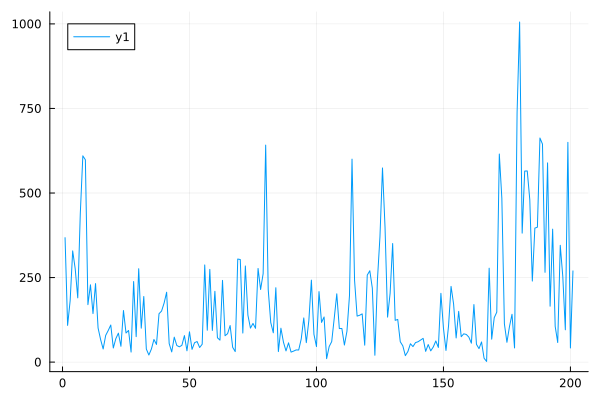

In [79]:
s = c["episodes"] - 200
plot(dqn.stats["loss"][s:end])
# plot!(twinx(), dqn.stats["randoms"][s:end], color=:red)
# savefig("../train.png") 
# plot(train_env.data.PnL)

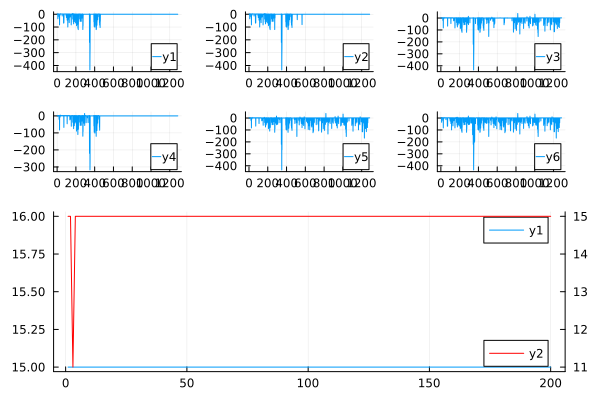

In [81]:
last = 5
bias = 0
top = 15
mm_stats = mm_eval.(eval_res)
two_completed = [n.two_completed for n in mm_stats]
one_completed = [n.one_completed for n in mm_stats]
reward = [n.reward for n in eval_res[end-last-bias:end-bias]]
println(eval_res[end].PnL[])
p1 = plot(reward, layout = last+1)
p2 = plot(min.(two_completed, top))
p2 = plot!(twinx(), min.(one_completed, top), color=:red)
plot(p1, p2, layout=(2,1))
# savefig("../test.png") 
# plot(test_env.data[:,"midprice"])

https://github.com/JuliaReinforcementLearning/ReinforcementLearningZoo.jl/pull/16/files


In [68]:
get_state(train_env)

Row,o_bid_px_1,o_ask_px_1,midprice,log_vwap_midprice_ratio_v130000.0,nlrr_ws2500,mean_trend_ws2500_midprice,std_trend_ws2500_midprice,vol_ws2500_midprice,mean_trend_ws2500_midprice_vwap_v130000.0,std_trend_ws2500_midprice_vwap_v130000.0,vol_ws2500_midprice_vwap_v130000.0,mean_trend_ws2500_midprice_vwap_v220000.0,std_trend_ws2500_midprice_vwap_v220000.0,vol_ws2500_midprice_vwap_v220000.0,new_trend_value_ws2500_midprice,new_trend_value_ws2500_midprice_vwap_v130000.0,new_trend_value_ws2500_midprice_vwap_v220000.0,Vol,posted_asks,posted_bids,PnL,Invested
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
120241,36029.5,36030.5,36030.0,-0.0841183,-2.09929,291959.0,837369.0,4583.26,312068.0,917504.0,5021.87,311426.0,915475.0,5010.76,0.0,0.0,0.0,0.0,0.0,4.0,-244.969,0.0


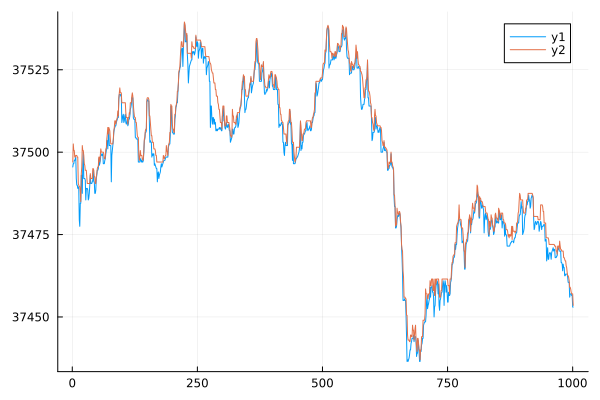

In [63]:
plot(Matrix(df[10000:11000, ["o_bid_px_1", "o_ask_px_1"]]))
# plot(df[10000:11000, "o_ask_px_1"], color=:red)

In [79]:
T_ = 100
SIGMA_NAME = "vol_ws2500_midprice_vwap_v130000.0"
function baseline(env, state, kwargs)
    delta = state[SIGMA_NAME] / 10000 * sqrt(T_)
    input_order(env, Order(true, 1.0, state["midprice"] + delta))
    input_order(env, Order(false, 1.0, state["midprice"] - delta))
end

res_base = simulate!(train_env, baseline, trading_step-1, nothing)

UndefVarError: UndefVarError: `trading_step` not defined

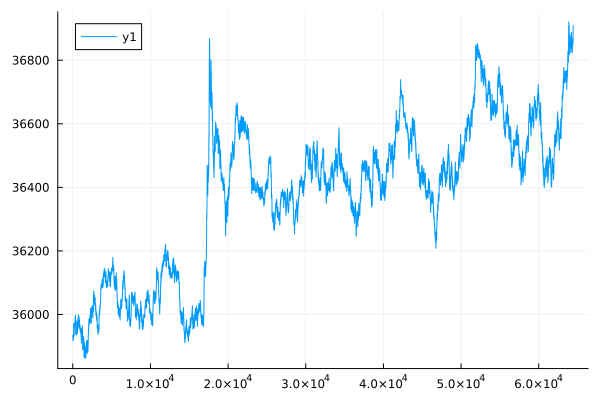

In [21]:
# plot(train_env.data[!, "midprice"])
plot(test_env.data[!, "midprice"])



In [65]:
dqn.predict_model[]([get_state(test_env, true)...])
# get_state(test_env, true)

5-element Vector{Float32}:
  0.04119462
 -1.1417181
 -0.5791068
 -0.06503381
 -0.6016929

In [88]:
include("BaseTypes.jl")

orders = [
    Order(true, 1.0, 130),
    Order(false, 1.0, 110)
]

res = match_orders!(
    orders=orders, best_ask = 109.0, best_bid = 129.0
)


  Activating project at `~/Desktop/RLFinance/alp`


MatchRes(1.0, -110.0, 1, 0, 1)

In [12]:
a = [0.1 2.0 3.0; 0.0 5.0 6.0; 0.0 9.0 8.0; 0.0 9.0 8.0]
b = [0.0 2.0 3.0 1.0; 1.0 2.0 3.0 2.0]
dt = StatsBase.fit(ZScoreTransform, a, dims=1)
hcat(StatsBase.transform(dt, b[:, 1:3]), b[:, 4:4])

2×4 Matrix{Float64}:
 -0.5  -1.24874  -1.37542  1.0
 19.5  -1.24874  -1.37542  2.0